<a href="https://colab.research.google.com/github/imyoungchae/Tensorflow_study/blob/main/tensorflow8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence (시계열) 데이터 다루기

Sunspots.csv를 활용하여 태양흑점활동을 예측하는 인공신경망을 만든다

# Import

In [1]:
import csv
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x7f23c94d72d0>)

# csv 파일로부터 Data Set 만들기
- csv.reader() 함수 활용
- 첫번째 파라미터에는 file을, delimiter에는 구분자를 넣어줌

In [3]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    i = 0
    for row in reader:
        print(row)
        i+=1
        if i > 10:
            break

['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']
['5', '1749-06-30', '139.2']
['6', '1749-07-31', '158.0']
['7', '1749-08-31', '110.5']
['8', '1749-09-30', '126.5']
['9', '1749-10-31', '125.8']
['10', '1749-11-30', '264.3']


빈 list만들어준다(sunspots,time_step)

In [4]:
sunspots = []
time_step = []

time_step에는 index값을

sunspots에는 sunspots의 정보를 넣어줌

In [5]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # 첫 줄은 header이므로 skip 합니다.
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

sunspots,time_step 확인

In [6]:
sunspots[:5]

[96.7, 104.3, 116.7, 92.8, 141.7]

In [7]:
time_step[:5]

[0, 1, 2, 3, 4]

sunspots와 time_step을 numpy array로 변환

In [8]:
series = np.array(sunspots)
time = np.array(time_step)

In [9]:
series.shape, time.shape

((3235,), (3235,))

# Sunspots 시각화

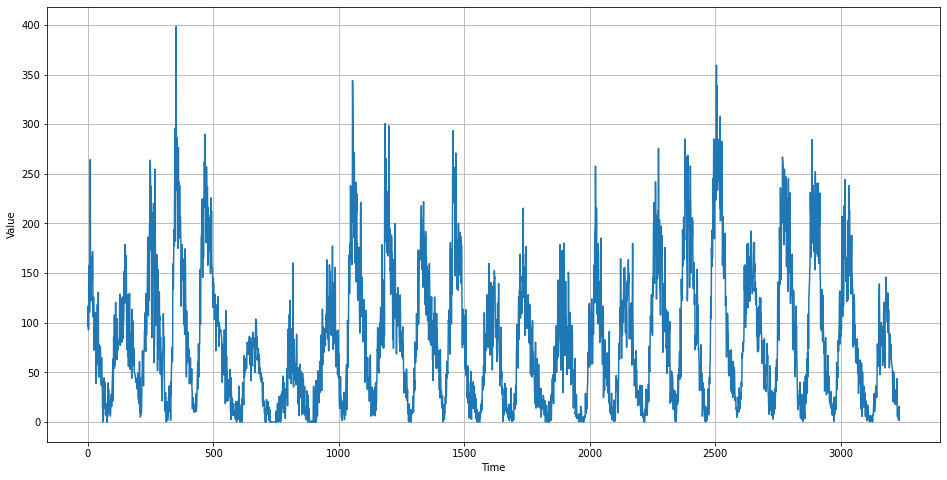

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

# Train Set, Validation Set 생성
- 3000 인덱스를 기준으로 Train/Validation Set을 분할

In [11]:
split_time = 3000

In [12]:
time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

# Window Dataset Loader

In [13]:
# 윈도우 사이즈
window_size=30
# 배치 사이즈
batch_size = 32
# 셔플 사이즈
shuffle_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

train_set과 validation_set을 만들어줌

In [15]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(x_valid, 
                                  window_size=window_size,
                                  batch_size=batch_size,
                                  shuffle_buffer=shuffle_size)

# Sequential

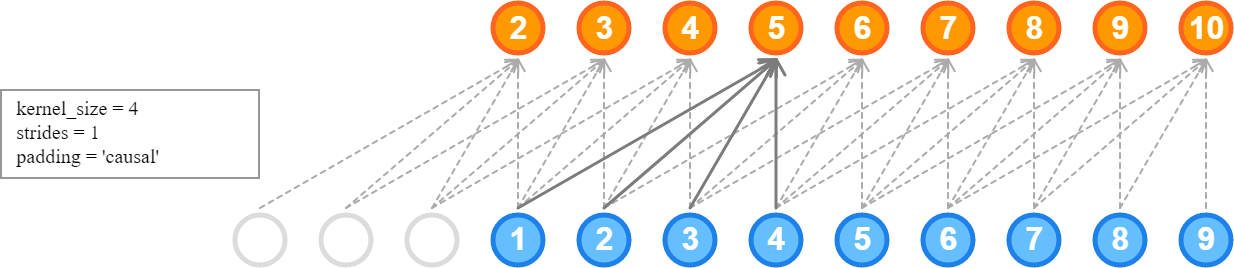

In [16]:
from IPython.display import Image

Image('https://i.stack.imgur.com/NmYZJ.png')

In [17]:
model = Sequential([
    tf.keras.layers.Conv1D(60, kernel_size=5,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

# Compile

Optimizer는 SGD(Stochastic Gradient Descent) 사용
- Ir(Learning_rate):학습률
- momentum: 가중치

In [19]:
optimizer = SGD(lr=1e-5, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Huber Loss: MSE와 MAE를 절충한 후버 손실

    - MSE:제곱 평균 오차
    - MAE:절대값 평균 오차

In [20]:
loss= Huber()

mode.compile()시 우리가 튜닝한 optimizer와 loss를 활용

In [21]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["mae"])

# ModelCheckpoint

In [22]:
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_mae',
                             verbose=1)

# Fit

In [23]:
epochs=100

In [24]:
history = model.fit(train_set, 
                    validation_data=(validation_set), 
                    epochs=epochs, 
                    callbacks=[checkpoint],
                   )

Epoch 1/100
     93/Unknown - 8s 41ms/step - loss: 31.0068 - mae: 31.5024
Epoch 1: val_mae improved from inf to 19.03226, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 10s 58ms/step - loss: 31.0068 - mae: 31.5024 - val_loss: 18.5407 - val_mae: 19.0323
Epoch 2/100
92/93 [============================>.] - ETA: 0s - loss: 23.4129 - mae: 23.9070
Epoch 2: val_mae did not improve from 19.03226
93/93 [==============================] - 4s 42ms/step - loss: 23.4057 - mae: 23.8998 - val_loss: 22.0802 - val_mae: 22.5758
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 20.8028 - mae: 21.2965
Epoch 3: val_mae improved from 19.03226 to 15.19825, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 4s 42ms/step - loss: 20.8028 - mae: 21.2965 - val_loss: 14.7074 - val_mae: 15.1982
Epoch 4/100
92/93 [============================>.] - ETA: 0s - loss: 19.3545 - mae: 19.8476
Epoch 4: val_mae did not improve from 15.19825
93/93 [===

# Load Weights

In [25]:
model.load_weights(checkpoint_path)

# 학습 오차에 대한 시각화

In [27]:
import matplotlib.pyplot as plt

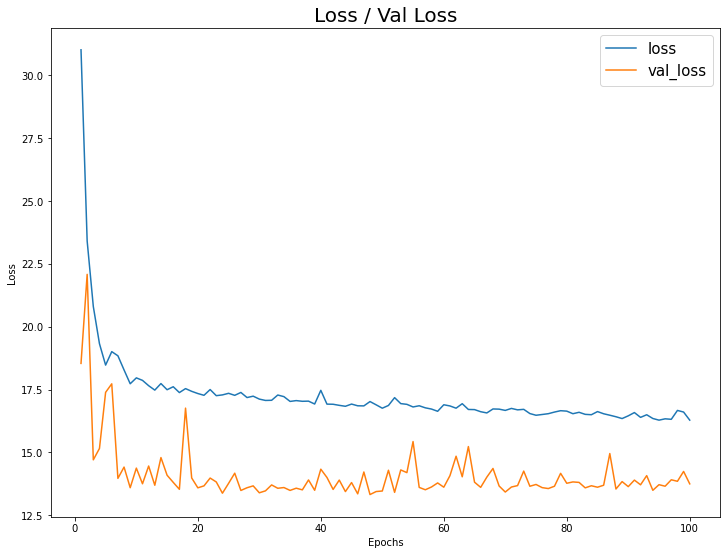

In [28]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

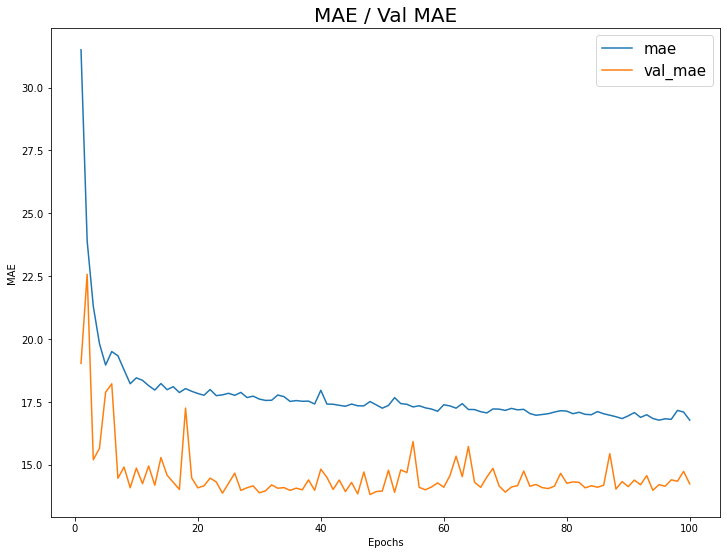

In [29]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['mae'])
plt.plot(np.arange(1, epochs+1), history.history['val_mae'])
plt.title('MAE / Val MAE', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['mae', 'val_mae'], fontsize=15)
plt.show()